# Image Segmentation V1

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorlayer as tl
import tf_clahe
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import skimage.morphology
from skimage.measure import label   
import math
import mclahe as mc
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
#dataset,info = tfds.load('curated_breast_imaging_ddsm/patches',split=['train','test','validation'],shuffle_files=True,
#                   with_info=True)
#ds_train,ds_test,ds_valid = dataset

In [35]:
dataset,info = tfds.load('curated_breast_imaging_ddsm/original-calc',split=['train','test'],shuffle_files=False,
                   with_info=True)
ds_train,ds_test = dataset

In [36]:
#fig = tfds.show_examples(ds_train,info)


In [37]:
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [38]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [39]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.squeeze(tf.image.resize(datapoint['abnormalities']['mask'], (128,128)),axis=0)
    
    #print(type(datapoint['image']).__name__)
    #print(type(input_image).__name__)
    
    #input_image = datapoint['image']
    #input_mask = datapoint['abnormalities']['mask']


    #input_image = tf.image.resize(datapoint['image'], tuple(datapoint['image'].get_shape().as_list()[0:2]))
    #input_mask = tf.squeeze(tf.image.resize(datapoint['abnormalities']['mask'], 
    #                                        tuple(datapoint['abnormalities']['mask'].get_shape().as_list()[0:2])),axis=0)
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [40]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['image'], (128,128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [41]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [42]:
train = ds_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = ds_test.map(load_image_test)

In [43]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [11]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image','True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [12]:
def display_images(display_list,titles):
    plt.figure(figsize=(15,15))
    nrow = int(np.ceil(len(display_list)/3))
    
    for i in range(len(display_list)):
        plt.subplot(nrow,3,i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    plt.show()

In [50]:
take1 = train.take(10)
for image, mask in take1:
    sample_image, sample_mask = image, mask

InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 3
	 [[{{node StatefulPartitionedCall/Squeeze}}]]

In [14]:
#display_images([sample_image, cropped_img, normalized_img,binarized_img,dilated_img,
#                selected_img,masked_img,flipped_img,padded_img],
#               ['Raw Image','Cropped Image','Normalized Image','Binarized Mask','Dilated Mask',
#                'Selected Mask','Mask Applied','Flipped Image','Padded Image'])

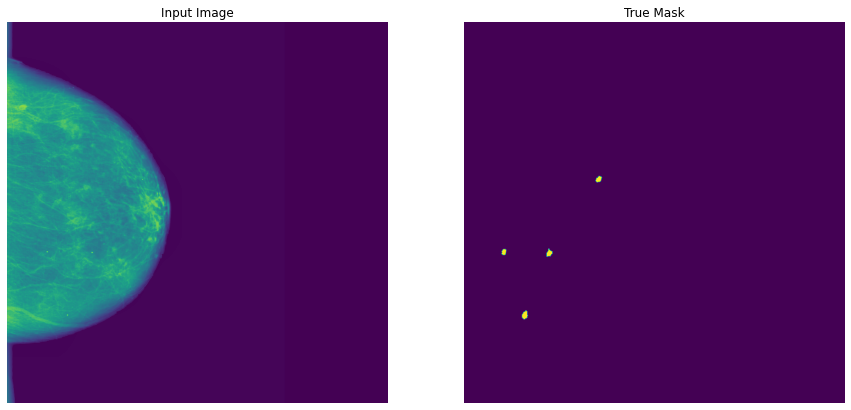

In [15]:
#for image, mask in train.take(1):
#    sample_image, sample_mask = image, mask
display([sample_image, np.sum(sample_mask,0)])

In [16]:
OUTPUT_CHANNELS = 1

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,1], include_top=False, weights=None)

layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [18]:
up_stack = [
    pix2pix.upsample(512,1),
    pix2pix.upsample(256,1),
    pix2pix.upsample(128,1),
    pix2pix.upsample(64,1),
]

In [19]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,1])
    
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    last = tf.keras.layers.Conv2DTranspose(output_channels, 1, strides=2, padding='same')
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [44]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

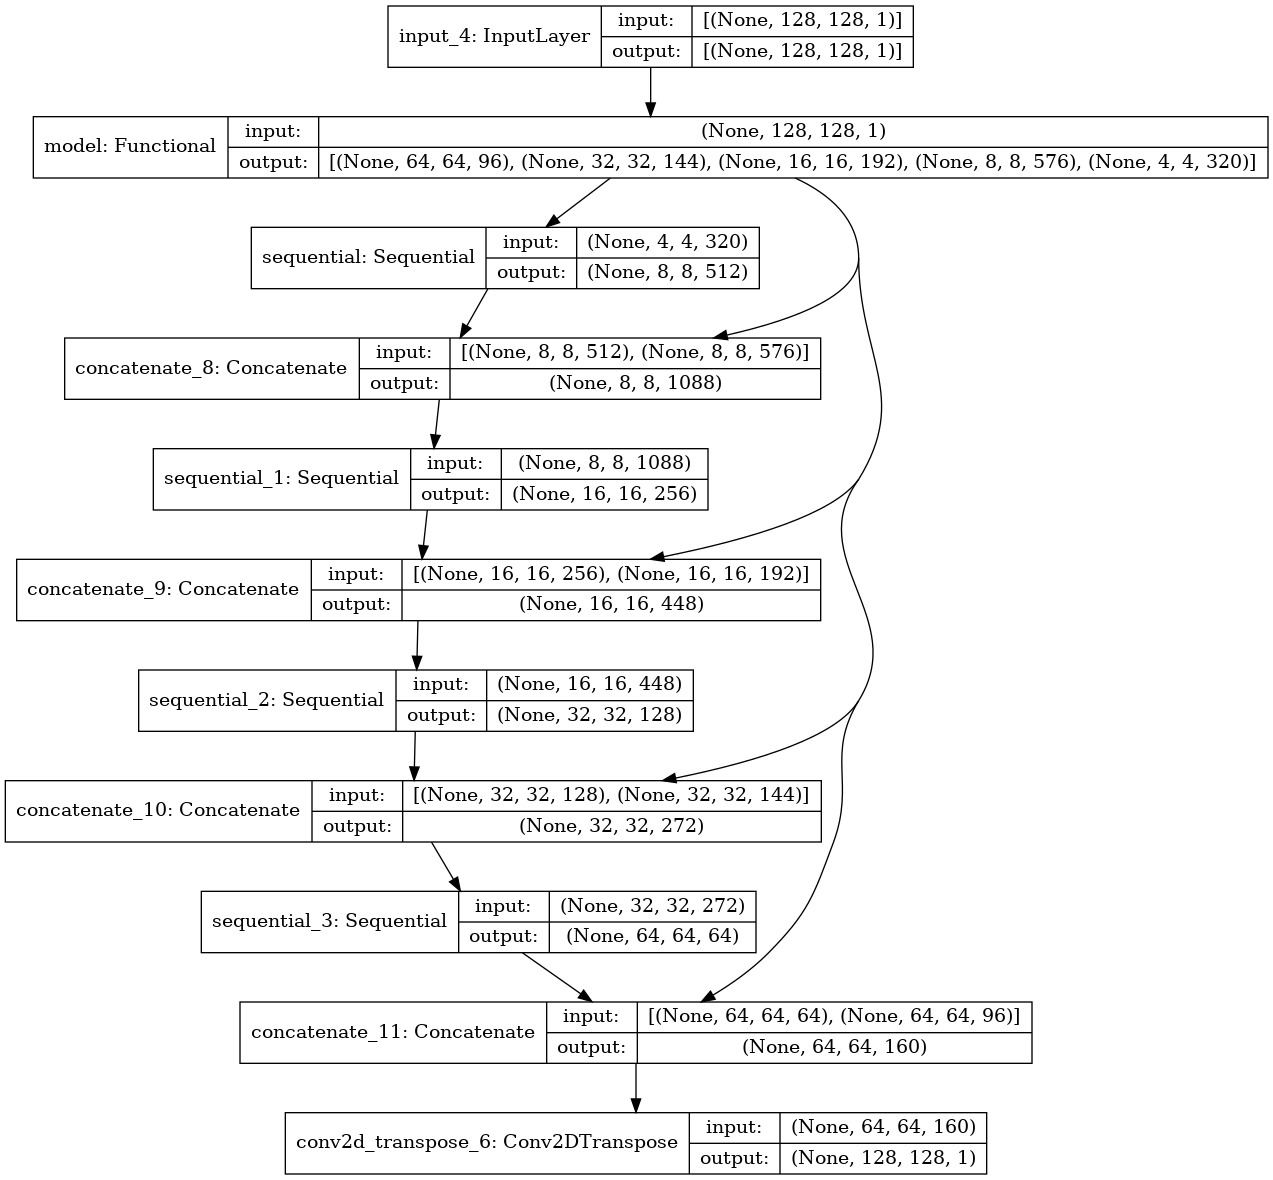

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [46]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [51]:
sample_image.shape

TensorShape([128, 128, 1])

In [52]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis,...]))])

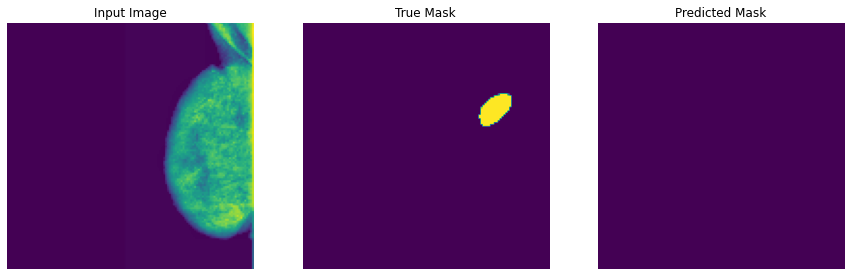

In [53]:
show_predictions()

In [54]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epic {}\n'.format(epoch+1))

In [55]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/20


InvalidArgumentError:  Can not squeeze dim[0], expected a dimension of 1, got 3
	 [[{{node StatefulPartitionedCall/Squeeze}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_13712]

Function call stack:
train_function
